In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa

# Analyze data

### Demographic information

In [34]:
df_demo = pd.read_csv('../data/ICBHI_Challenge_demographic_information.txt', sep='\t', header=None)
df_demo = df_demo.rename(columns={0: 'ID', 1: 'age', 2: 'sex', 3: 'BMI', 4: 'weight', 5: 'height'})
df_diagnosis = pd.read_csv('../data/ICBHI_Challenge_diagnosis.txt', sep='\t', header=None)
df_diagnosis = df_diagnosis.rename(columns={0: 'ID', 1: 'diagnosis'})

df = pd.merge(df_demo, df_diagnosis, on='ID')
df.head()

,ID,age,sex,BMI,weight,height,diagnosis
0,101,3.00,F,NaN,19.0,99.0,URTI
1,102,0.75,F,NaN,9.8,73.0,Healthy
2,103,70.00,F,33.00,NaN,NaN,Asthma
3,104,70.00,F,28.47,NaN,NaN,COPD
4,105,7.00,F,NaN,32.0,135.0,URTI


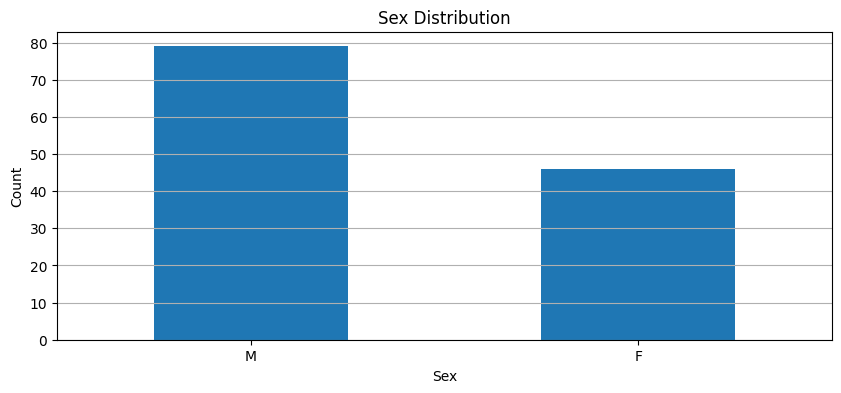

In [35]:
plt.figure(figsize=(10, 4))
df['sex'].value_counts().plot(kind='bar')
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.show()

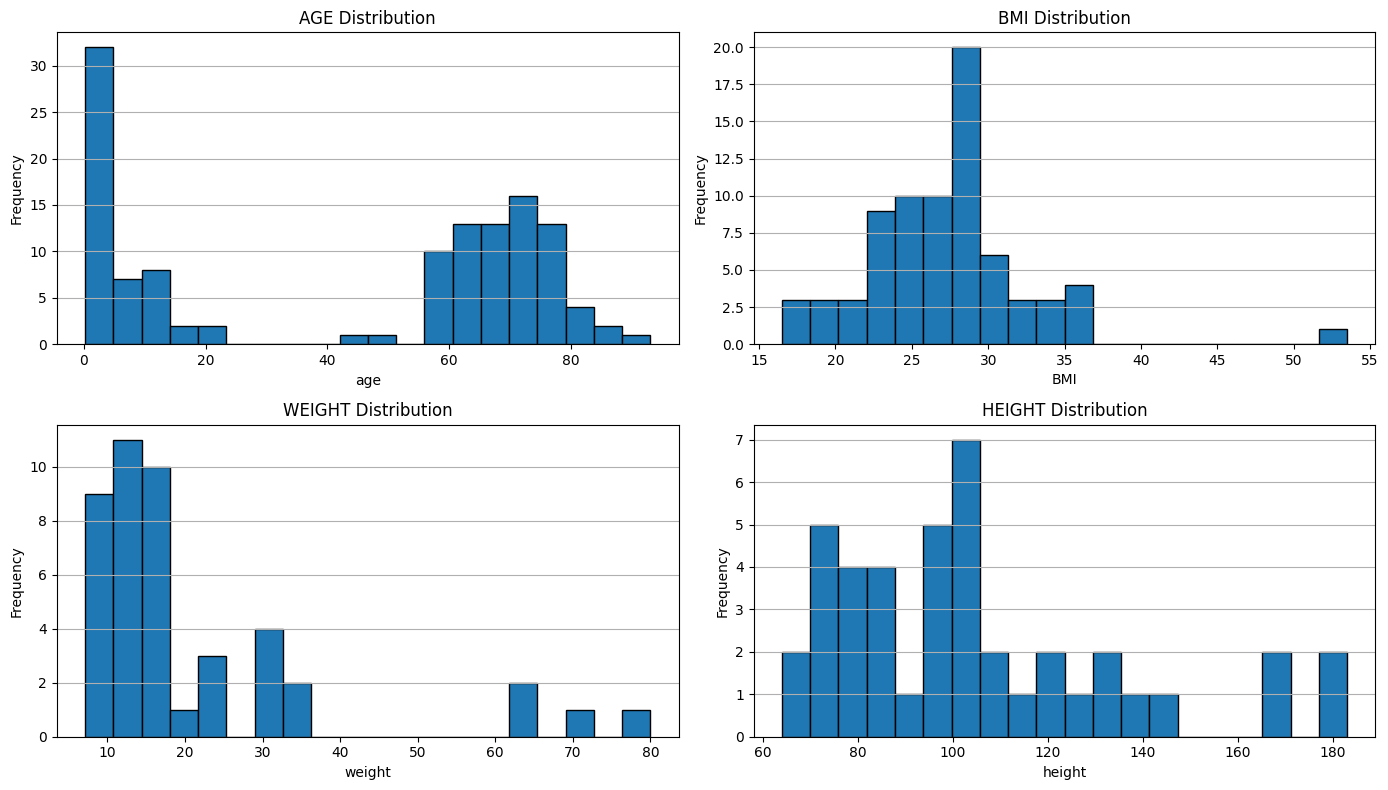

In [36]:
fig, axs = plt.subplots(2,2, figsize=(14, 8))

columns = ['age', 'BMI', 'weight', 'height']
plot_num = 0

for i in range(2):
    for j in range(2):       
        
        axs[i, j].hist(df[columns[plot_num]], bins=20, edgecolor='black')
        axs[i, j].set_title(f'{columns[plot_num].upper()} Distribution')
        axs[i, j].set_xlabel(columns[plot_num])
        axs[i, j].set_ylabel('Frequency')
        axs[i, j].grid(axis='y')
        
        plot_num += 1
plt.tight_layout()
plt.show()

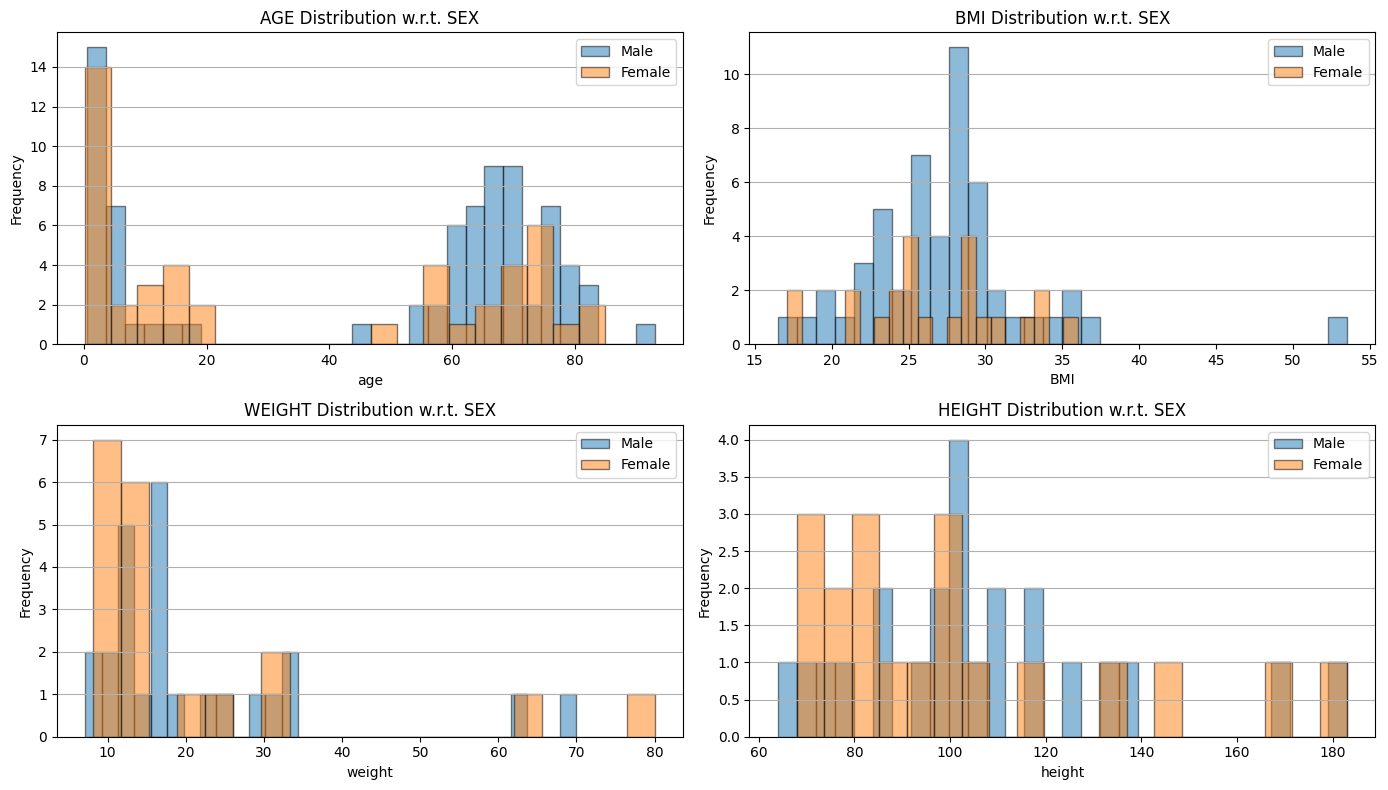

In [37]:
fig, axs = plt.subplots(2,2, figsize=(14, 8))

columns = ['age', 'BMI', 'weight', 'height']
plot_num = 0

for i in range(2):
    for j in range(2):       
        
        axs[i, j].hist(df[df['sex'] == 'M'][columns[plot_num]], bins=30, alpha=0.5, edgecolor='black', label='Male')
        axs[i, j].hist(df[df['sex'] == 'F'][columns[plot_num]], bins=20, alpha=0.5, edgecolor='black', label='Female')
        axs[i, j].set_title(f'{columns[plot_num].upper()} Distribution w.r.t. SEX')
        axs[i, j].set_xlabel(columns[plot_num])
        axs[i, j].set_ylabel('Frequency')
        axs[i, j].grid(axis='y')
        axs[i, j].legend()
        
        plot_num += 1
plt.tight_layout()
plt.show()

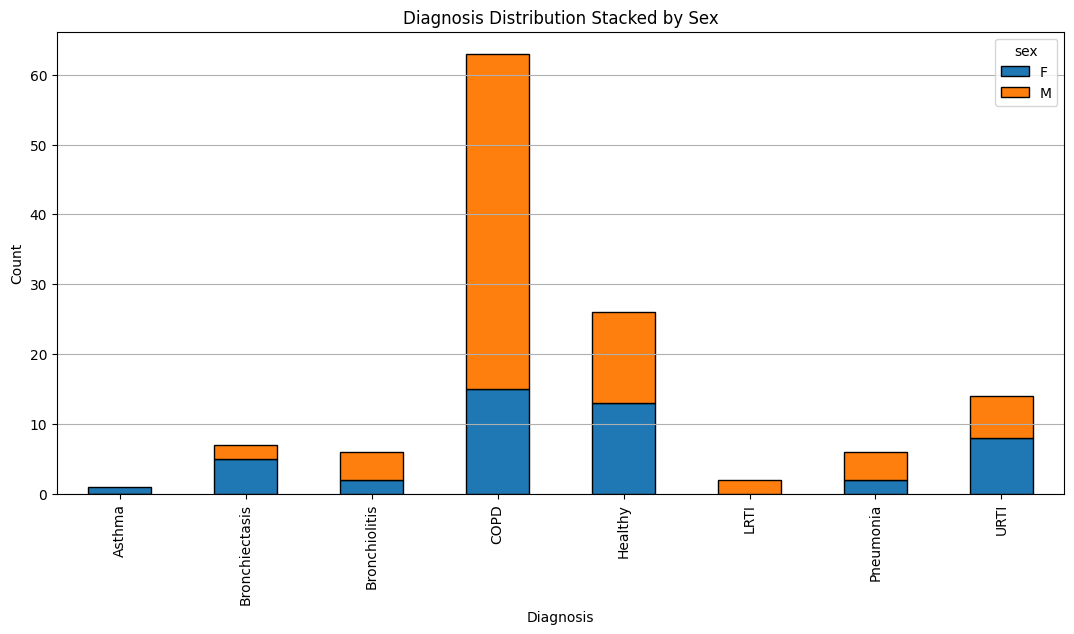

In [38]:
plt.figure(figsize=(13, 6))

df.groupby(['diagnosis', 'sex']).size().unstack().plot(kind='bar', stacked=True, ax=plt.gca(), edgecolor='black')

plt.title('Diagnosis Distribution Stacked by Sex')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

## Detailed events analysis

In [39]:
df_events = pd.DataFrame([])

for file_name in os.listdir('../data/events/'):
    file_path = os.path.join('../data/events/', file_name)

    if os.path.getsize(file_path) == 0:
        continue
    
    df = pd.read_csv(file_path, sep='\t', header=None, names=['start_time', 'end_time', 'event'])
    df['duration'] = data['end_time'] - data['start_time']
    df['event'] = df['event'].str.strip()
    
    df_events = pd.concat([df_events, df], axis=0)

df_events.head()

,start_time,end_time,event,duration
0,0.350,0.371,crackle,0.026
1,0.789,0.822,crackle,0.017
2,2.085,2.113,crackle,0.898
3,2.121,2.155,crackle,0.019
4,2.463,2.506,crackle,0.021


Total Events: 10939
Total crackles: 8877 (81.15%)
Total wheeze: 1898 (17.35%)
Total none: 164 (1.50%)


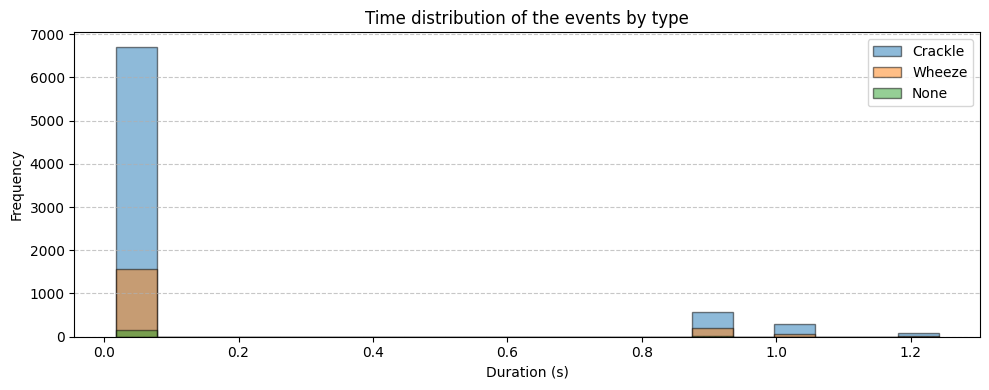

In [45]:
df_crackle = df_events[df_events['event'] == 'crackle']
df_wheeze = df_events[df_events['event'] == 'wheeze']
df_none = df_events[~df_events['event'].isin(['crackle', 'wheeze'])]

print(f"Total Events: {len(df_events)}")
print(f"Total crackles: {len(df_crackle)} ({len(df_crackle)/len(df_events)*100:.2f}%)")
print(f"Total wheeze: {len(df_wheeze)} ({len(df_wheeze)/len(df_events)*100:.2f}%)")
print(f"Total none: {len(df_none)} ({len(df_none)/len(df_events)*100:.2f}%)")

plt.figure(figsize=(10, 4))
plt.hist(df_crackle['duration'], bins=20, alpha=0.5, label='Crackle', edgecolor='black')
plt.hist(df_wheeze['duration'], bins=20, alpha=0.5, label='Wheeze', edgecolor='black')
plt.hist(df_none['duration'], bins=20, alpha=0.5, label='None', edgecolor='black')
plt.xlabel('Duration (s)')
plt.ylabel('Frequency')
plt.title('Time distribution of the events by type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## Experts annotations

In [72]:
data_list = []

for file_name in os.listdir('../data/ICBHI_final_database/'):
    if file_name.endswith('.txt'):
        file_path = os.path.join('../data/ICBHI_final_database/', file_name)
        
        df = pd.read_csv(file_path, sep="\t", header=None, names=["start_time", "end_time", "crackle", "wheeze"])

        data_list.append(df)

df_experts = pd.concat(data_list, ignore_index=True)
df_experts['duration'] = df_experts['end_time'] - df_experts['start_time']

print(f"Total Cycles: {total_rows}")
print(f"Total Crackles: {df_experts['crackle'].sum()} ({df_experts['crackle'].sum()/len(df_experts)*100:.2f}%)")
print(f"Total Wheezes: {df_experts['wheeze'].sum()} ({df_experts['wheeze'].sum()/len(df_experts)*100:.2f}%)")

print(f"\nAverage cycle duration: {df_experts['duration'].mean():.2f} seconds")
print(f"Average cycle duration - Crackles: {df_experts[df_experts['crackle'] > 0]['duration'].mean():.2f} seconds")
print(f"Average cycle duration - Wheezes: {df_experts[df_experts['wheeze'] > 0]['duration'].mean():.2f} seconds\n")

df_experts.head()

Total Cycles: 6995
Total Crackles: 2370.0 (33.88%)
Total Wheezes: 1392.0 (19.90%)

Average cycle duration: 2.70 seconds
Average cycle duration - Crackles: 2.84 seconds
Average cycle duration - Wheezes: 2.83 seconds



,start_time,end_time,crackle,wheeze,duration
0,0.0,1.0665,0.0,0.0,1.0665
1,1.0665,2.5256,0.0,0.0,1.4591
2,2.5256,4.7475,0.0,0.0,2.2219
3,4.7475,7.2102,0.0,0.0,2.4627
4,7.2102,10.0620,0.0,0.0,2.8518


/nas/home/dsalvi/miniconda3/envs/ICBHI_2017/lib/python3.8/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/nas/home/dsalvi/miniconda3/envs/ICBHI_2017/lib/python3.8/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


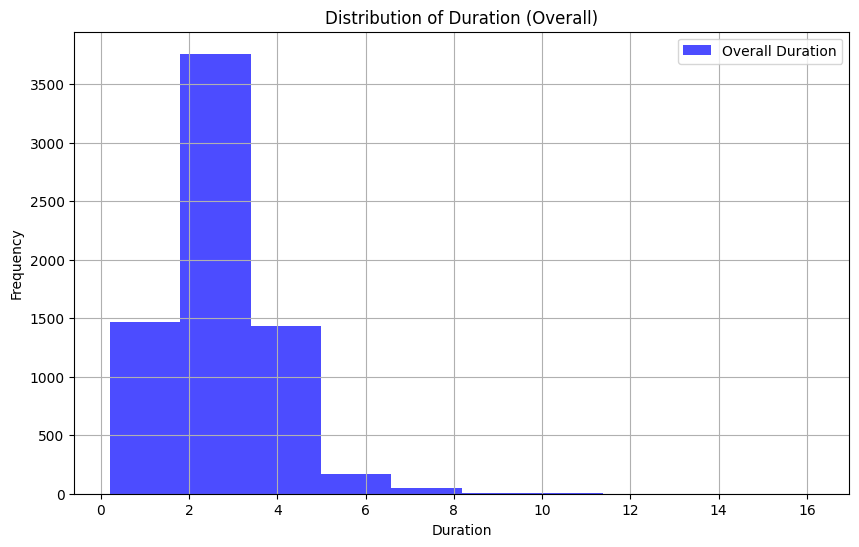

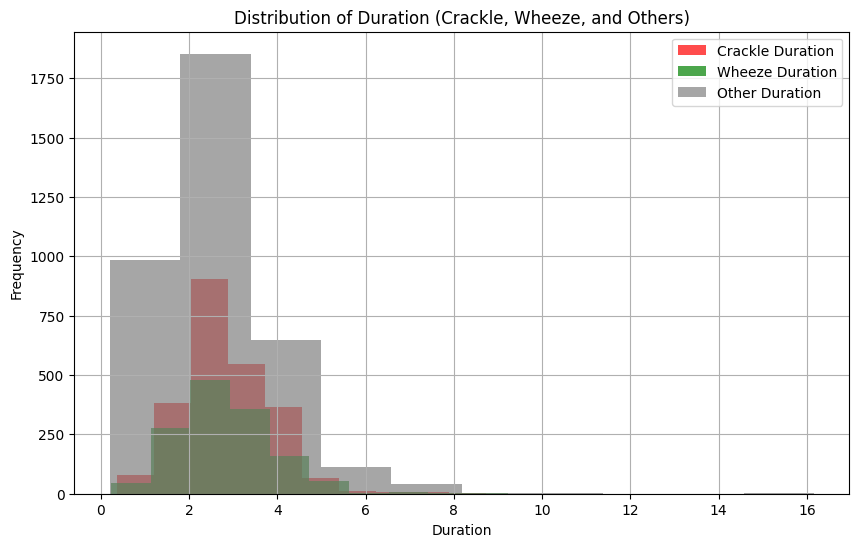

In [73]:
import matplotlib.pyplot as plt

# Plot the overall distribution of the duration
plt.figure(figsize=(10, 6))
plt.hist(df_experts['duration'], bins=10, alpha=0.7, label="Overall Duration", color='blue')
plt.title("Distribution of Duration (Overall)")
plt.xlabel("Duration")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# Plot the distribution for crackles, wheezes, and others
plt.figure(figsize=(10, 6))

# Crackle durations
crackle_duration = df_experts[df_experts['crackle'] > 0]['duration']
plt.hist(crackle_duration, bins=10, alpha=0.7, label="Crackle Duration", color='red')

# Wheeze durations
wheeze_duration = df_experts[df_experts['wheeze'] > 0]['duration']
plt.hist(wheeze_duration, bins=10, alpha=0.7, label="Wheeze Duration", color='green')

# Other durations (no crackle or wheeze)
others_duration = df_experts[(df_experts['crackle'] == 0) & (df_experts['wheeze'] == 0)]['duration']
plt.hist(others_duration, bins=10, alpha=0.7, label="Other Duration", color='gray')

# Title and labels
plt.title("Distribution of Duration (Crackle, Wheeze, and Others)")
plt.xlabel("Duration")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


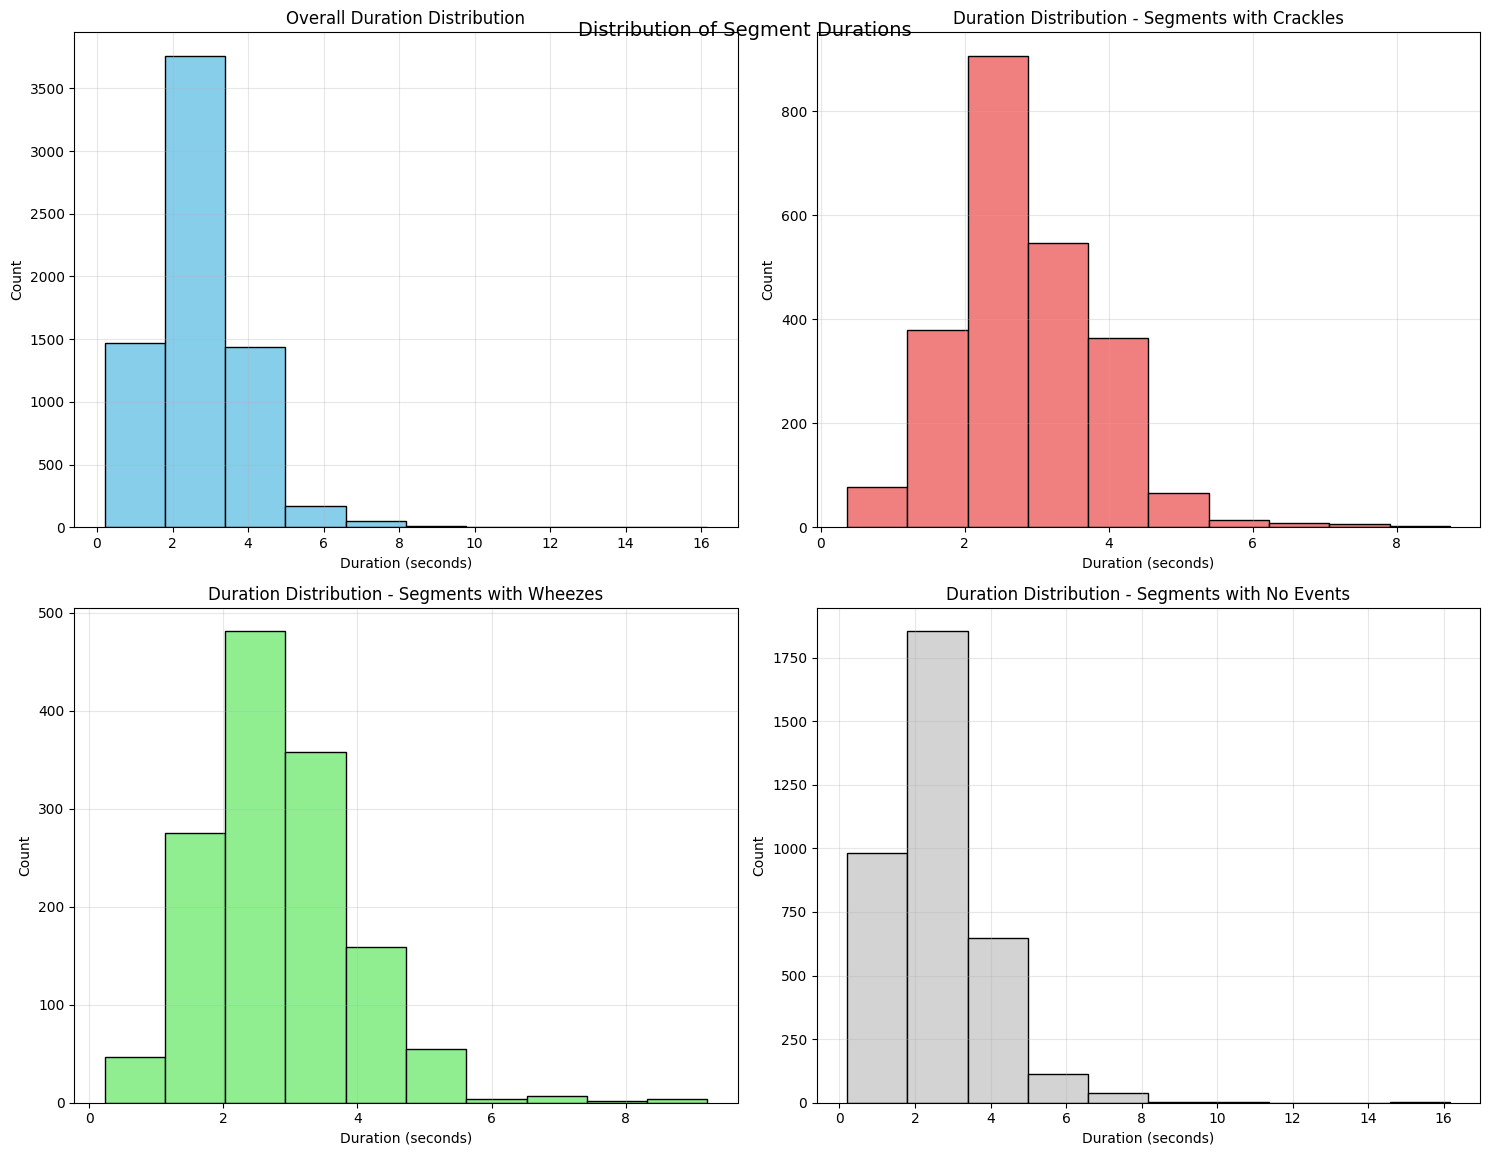

In [74]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Distribution of Segment Durations', fontsize=14, y=0.95)

# Overall duration distribution
axs[0, 0].hist(df_experts['duration'], bins=10, edgecolor='black', color='skyblue')
axs[0, 0].set_title('Overall Duration Distribution')
axs[0, 0].set_xlabel('Duration (seconds)')
axs[0, 0].set_ylabel('Count')
axs[0, 0].grid(True, alpha=0.3)

# Duration distribution for segments with crackles
crackle_durations = df_experts[df_experts['crackle'] > 0]['duration']
axs[0, 1].hist(crackle_durations, bins=10, edgecolor='black', color='lightcoral')
axs[0, 1].set_title('Duration Distribution - Segments with Crackles')
axs[0, 1].set_xlabel('Duration (seconds)')
axs[0, 1].set_ylabel('Count')
axs[0, 1].grid(True, alpha=0.3)

# Duration distribution for segments with wheezes
wheeze_durations = df_experts[df_experts['wheeze'] > 0]['duration']
axs[1, 0].hist(wheeze_durations, bins=10, edgecolor='black', color='lightgreen')
axs[1, 0].set_title('Duration Distribution - Segments with Wheezes')
axs[1, 0].set_xlabel('Duration (seconds)')
axs[1, 0].set_ylabel('Count')
axs[1, 0].grid(True, alpha=0.3)

# Duration distribution for segments with no events
normal_durations = df_experts[(df_experts['crackle'] == 0) & (df_experts['wheeze'] == 0)]['duration']
axs[1, 1].hist(normal_durations, bins=10, edgecolor='black', color='lightgray')
axs[1, 1].set_title('Duration Distribution - Segments with No Events')
axs[1, 1].set_xlabel('Duration (seconds)')
axs[1, 1].set_ylabel('Count')
axs[1, 1].grid(True, alpha=0.3)

plt.tight_layout()

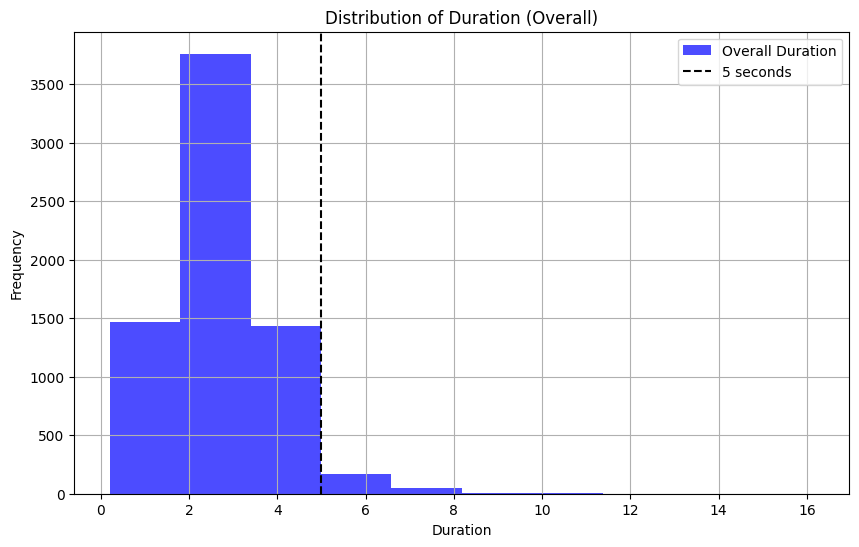

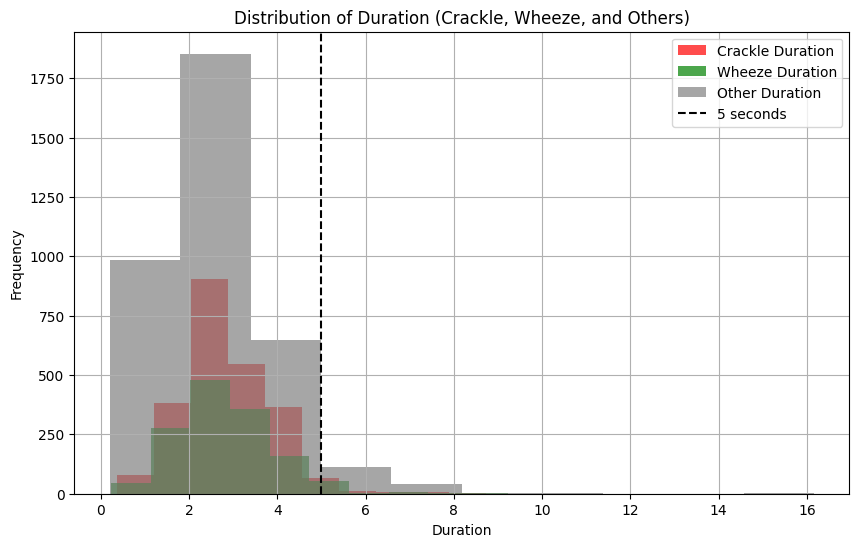

Percentage of cycles shorter than 5 seconds (Overall): 95.27%
Percentage of crackle cycles shorter than 5 seconds: 97.81%
Percentage of wheeze cycles shorter than 5 seconds: 96.34%


In [76]:
# Plot the overall distribution of the duration with vertical line at 5 seconds
plt.figure(figsize=(10, 6))
plt.hist(df_experts['duration'], bins=10, alpha=0.7, label="Overall Duration", color='blue')
plt.axvline(x=5, color='black', linestyle='--', label="5 seconds")
plt.title("Distribution of Duration (Overall)")
plt.xlabel("Duration")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# Plot the distribution for crackles, wheezes, and others with vertical line at 5 seconds
plt.figure(figsize=(10, 6))

# Crackle durations
crackle_duration = df_experts[df_experts['crackle'] > 0]['duration']
plt.hist(crackle_duration, bins=10, alpha=0.7, label="Crackle Duration", color='red')

# Wheeze durations
wheeze_duration = df_experts[df_experts['wheeze'] > 0]['duration']
plt.hist(wheeze_duration, bins=10, alpha=0.7, label="Wheeze Duration", color='green')

# Other durations (no crackle or wheeze)
others_duration = df_experts[(df_experts['crackle'] == 0) & (df_experts['wheeze'] == 0)]['duration']
plt.hist(others_duration, bins=10, alpha=0.7, label="Other Duration", color='gray')

# Add vertical line at 5 seconds
plt.axvline(x=5, color='black', linestyle='--', label="5 seconds")

# Title and labels
plt.title("Distribution of Duration (Crackle, Wheeze, and Others)")
plt.xlabel("Duration")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# Calculate and print the percentage of cycles shorter than 5 seconds
shorter_than_5 = (df_experts['duration'] < 5).sum()
total_cycles = len(df_experts)
percentage_shorter_than_5 = (shorter_than_5 / total_cycles) * 100

# Calculate the percentage of cycles shorter than 5 seconds overall
shorter_than_5_overall = (df_experts['duration'] < 5).sum()
percentage_shorter_than_5_overall = (shorter_than_5_overall / total_cycles) * 100

# Calculate the percentage of crackle cycles shorter than 5 seconds
shorter_than_5_crackle = (df_experts[df_experts['crackle'] > 0]['duration'] < 5).sum()
total_crackle_cycles = len(df_experts[df_experts['crackle'] > 0])
percentage_shorter_than_5_crackle = (shorter_than_5_crackle / total_crackle_cycles) * 100 if total_crackle_cycles > 0 else 0

# Calculate the percentage of wheeze cycles shorter than 5 seconds
shorter_than_5_wheeze = (df_experts[df_experts['wheeze'] > 0]['duration'] < 5).sum()
total_wheeze_cycles = len(df_experts[df_experts['wheeze'] > 0])
percentage_shorter_than_5_wheeze = (shorter_than_5_wheeze / total_wheeze_cycles) * 100 if total_wheeze_cycles > 0 else 0

# Print the results
print(f"Percentage of cycles shorter than 5 seconds (Overall): {percentage_shorter_than_5_overall:.2f}%")
print(f"Percentage of crackle cycles shorter than 5 seconds: {percentage_shorter_than_5_crackle:.2f}%")
print(f"Percentage of wheeze cycles shorter than 5 seconds: {percentage_shorter_than_5_wheeze:.2f}%")
